In [1]:
import requests
import csv
from zipfile import ZipFile

import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

# Objetivo

Explorar os microdados da primeira edição da PNAD COVID e testar uma versão simplificada do modelo de Mincer para determinação do prêmio salarial de anos de educação.

# Obtendo os Dados

## PNAD_COVID 05/20

In [ ]:
url_pnad_cov05 = 'https://ftp.ibge.gov.br/Trabalho_e_Rendimento/Pesquisa_Nacional_por_Amostra_de_Domicilios_PNAD_COVID19/Microdados/Dados/PNAD_COVID_052020.zip'

In [ ]:
url_pnad_cov08 = 'https://ftp.ibge.gov.br/Trabalho_e_Rendimento/Pesquisa_Nacional_por_Amostra_de_Domicilios_PNAD_COVID19/Microdados/Dados/PNAD_COVID_082020.zip'

In [ ]:
req_pnad_cov05 = requests.get(url_pnad_cov05, stream = True)
with open('pnad_cov05.zip','wb') as fd:
  for chunk in req_pnad_cov05.iter_content(chunk_size=10000):
    fd.write(chunk)

In [2]:
!wget https://ftp.ibge.gov.br/Trabalho_e_Rendimento/Pesquisa_Nacional_por_Amostra_de_Domicilios_PNAD_COVID19/Microdados/Dados/PNAD_COVID_052020.zip

--2021-05-28 04:44:32--  https://ftp.ibge.gov.br/Trabalho_e_Rendimento/Pesquisa_Nacional_por_Amostra_de_Domicilios_PNAD_COVID19/Microdados/Dados/PNAD_COVID_052020.zip
Resolving ftp.ibge.gov.br (ftp.ibge.gov.br)... 170.84.40.44
Connecting to ftp.ibge.gov.br (ftp.ibge.gov.br)|170.84.40.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9498337 (9.1M) [application/zip]
Saving to: ‘PNAD_COVID_052020.zip’

PNAD_COVID_052020.z 100%[===================>]   9.06M  1.05MB/s    in 9.7s    

2021-05-28 04:44:43 (960 KB/s) - ‘PNAD_COVID_052020.zip’ saved [9498337/9498337]



In [3]:
ZipFile('/content/PNAD_COVID_052020.zip','r').extractall('PNAD_COV05')

### Análise Exploratória

In [7]:
pnad_cov = pd.read_csv('/content/PNAD_COV05/PNAD_COVID_052020.csv')

#### Proporção de Gênero na Amostra

In [5]:
# A003 - Sexo
#           1 = Homem  |  2 = Mulher

pnad_cov['A003'].map({1:'Homem', 2:'Mulher'}).value_counts(normalize = True) * 100

Mulher    51.987083
Homem     48.012917
Name: A003, dtype: float64

### Proporção de Etnia na Amostra

In [6]:
# A004 - Cor ou Raça 
#        1 = Branca  |  2 = Preta | 3 = Amarela | 4 = Parda | 5 = Indígena

pnad_cov['A004'].map({1 : 'Branca',2 : 'Preta',3 : 'Amarela', 4 : 'Parda', 5 : 'Indígena', 9: 'Não Declarado'}).value_counts(normalize = True) * 100

Parda            48.414284
Branca           42.287564
Preta             8.216005
Amarela           0.662456
Indígena          0.381900
Não Declarado     0.037789
Name: A004, dtype: float64

### Trabalho Remoto

In [ ]:
# CO13 - Na semana passada, estava em trabalho remoto? 
#                                 1 = Sim  |  2 = Não

pnad_cov['C013'].map({1: 'Sim', 2:'Não'}).value_counts(normalize = True) * 100

Sim    70.48821
Não    29.51179
Name: C013, dtype: float64

### Recebimento de Auxílio Emergencial

In [ ]:
# D0051 - Recebeu auxilio emergencial relacionado ao Covid? 
#                                 1 = Sim  |  2 = Não

pnad_cov['D0051'].map({1:'Sim', 2:'Não'}).value_counts(normalize = True) * 100

Não    53.945824
Sim    46.054176
Name: D0051, dtype: float64

### Trabalho Remoto, por Etnia

In [8]:
# A004 - Cor ou Raça 
#        1 = Branca  |  2 = Preta | 3 = Amarela | 4 = Parda | 5 = Indígena

# CO13 - Na semana passada, estava em trabalho remoto? 
#                                 1 = Sim  |  2 = Não

remoto_etnia = pnad_cov.groupby('A004')['C013'].value_counts(normalize = True) * 100

In [9]:
remoto_etnia.index.set_levels([remoto_etnia.index.levels[0].map({1 : 'Branca',  2 : 'Preta', 3 : 'Amarela', 4 : 'Parda', 5 : 'Indígena', 9: 'Não Disponível'}),
                               remoto_etnia.index.levels[1].map({1:'Sim', 2:'Não'})], 
                              level=[0,1],
                              inplace = True)

In [10]:
remoto_etnia

A004            C013
Branca          Sim     78.316690
                Não     21.683310
Preta           Sim     61.702128
                Não     38.297872
Amarela         Sim     77.368421
                Não     22.631579
Parda           Sim     60.783997
                Não     39.216003
Indígena        Sim     56.140351
                Não     43.859649
Não Disponível  Não     66.666667
                Sim     33.333333
Name: C013, dtype: float64

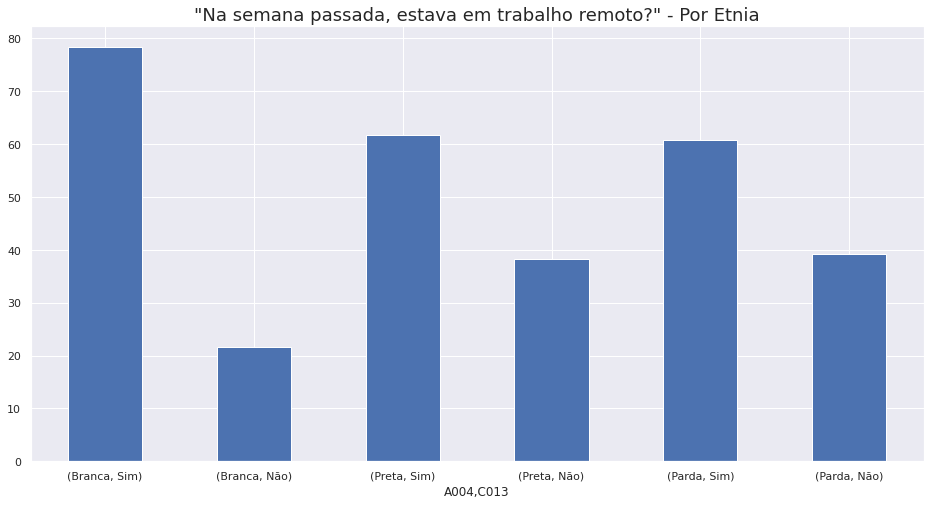

In [ ]:
sns.set()

remoto_etnia.loc[['Branca','Preta','Parda']].plot.bar(figsize = (16,8))
plt.title('"Na semana passada, estava em trabalho remoto?" - Por Etnia', fontsize = 18)
plt.xticks(rotation = 0)

plt.show()

### Recebimento de Auxílio, por Etnia

In [ ]:
etnia_auxilio = pnad_cov.groupby('A004')['D0051'].value_counts(normalize = True) * 100

In [ ]:
etnia_auxilio.index.set_levels([etnia_auxilio.index.levels[0].map({1 : 'Branca',  2 : 'Preta', 3 : 'Amarela', 4 : 'Parda', 5 : 'Indígena', 9: 'Não Disponível'}),
                               etnia_auxilio.index.levels[1].map({1:'Sim', 2:'Não'})], 
                              level=[0,1],
                              inplace = True)

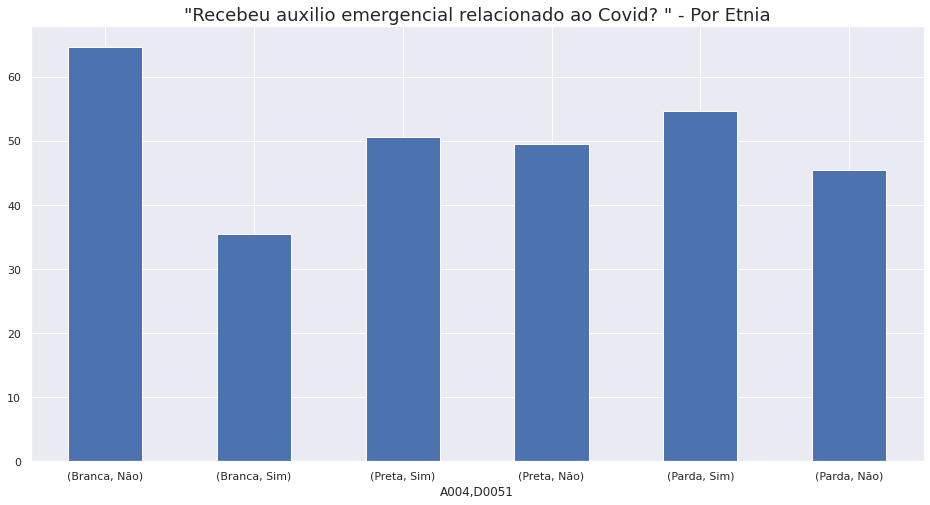

In [ ]:
etnia_auxilio.loc[['Branca','Preta','Parda']].plot.bar(figsize = (16,8))
plt.title('"Recebeu auxilio emergencial relacionado ao Covid? " - Por Etnia', fontsize = 18)
plt.xticks(rotation = 0)

plt.show()

### Trabalho Remoto, por Sexo

In [ ]:
genero_remoto = pnad_cov.groupby('A003')['C013'].value_counts(normalize = True) * 100

In [ ]:
genero_remoto.index.set_levels([genero_remoto.index.levels[0].map({1 : 'Homem',  2 : 'Mulher'}),
                               genero_remoto.index.levels[1].map({1:'Sim', 2:'Não'})], 
                              level=[0,1],
                              inplace = True)

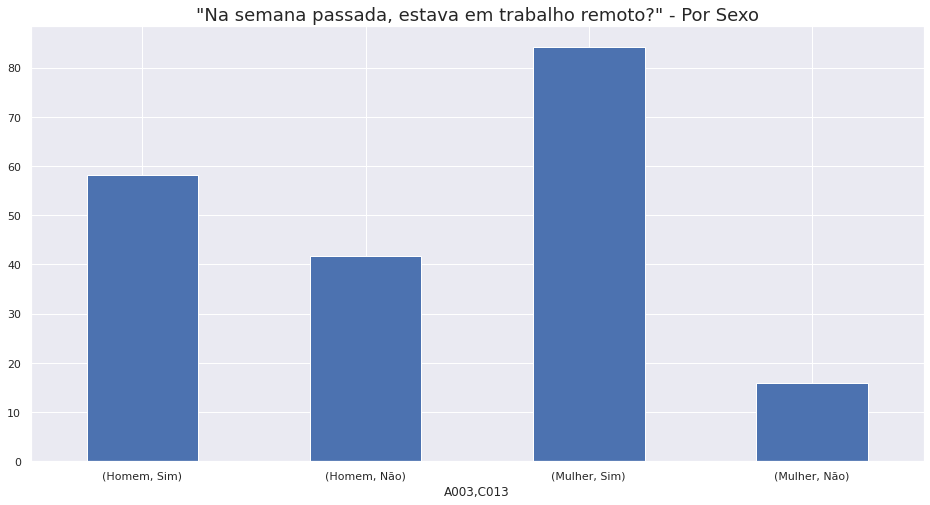

In [ ]:
genero_remoto.plot.bar(figsize = (16,8))
plt.title('"Na semana passada, estava em trabalho remoto?" - Por Sexo', fontsize = 18)
plt.xticks(rotation = 0)

plt.show()

### Recebimento de Auxílio, por Gênero

In [ ]:
genero_auxilio = pnad_cov.groupby('A003')['D0051'].value_counts(normalize = True) * 100

In [ ]:
genero_auxilio.index.set_levels([genero_auxilio.index.levels[0].map({1 : 'Homem',  2 : 'Mulher'}),
                               genero_auxilio.index.levels[1].map({1:'Sim', 2:'Não'})], 
                              level=[0,1],
                              inplace = True)

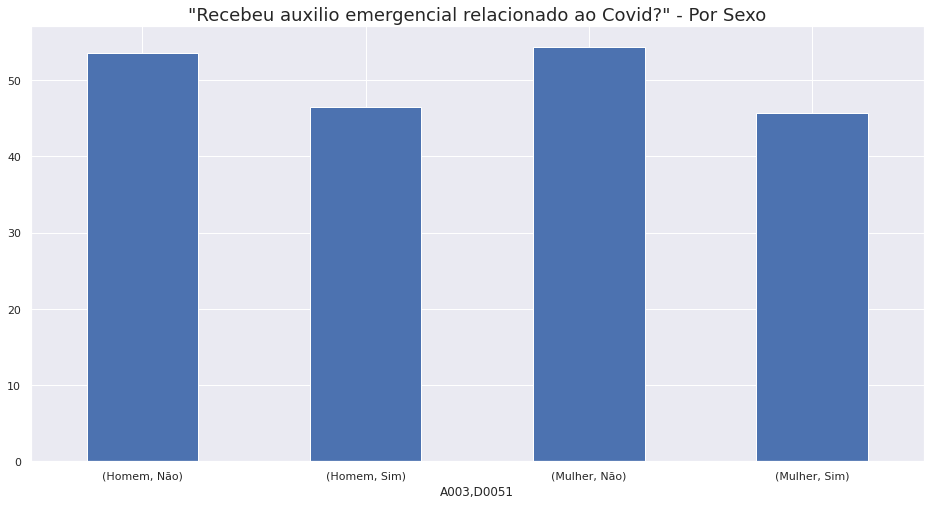

In [ ]:
genero_auxilio.plot.bar(figsize = (16,8))
plt.title('"Recebeu auxilio emergencial relacionado ao Covid?" - Por Sexo', fontsize = 18)
plt.xticks(rotation = 0)

plt.show()

### Recebimento de Auxílio, por Sexo e Etnia

In [ ]:
# A003 - Sexo
#           1 = Homem  |  2 = Mulher

# A004 - Cor ou Raça 
#        1 = Branca  |  2 = Preta | 3 = Amarela | 4 = Parda | 5 = Indígena

# D0051 - Recebeu auxilio emergencial relacionado ao Covid? 
#                                 1 = Sim  |  2 = Não

auxilio_sexo_etnia = pnad_cov.groupby(['A003','A004'])['D0051'].value_counts(normalize = True) * 100

In [ ]:
auxilio_sexo_etnia.index.set_levels([auxilio_sexo_etnia.index.levels[0].map({1 : 'Homem',  2 : 'Mulher'}),
                                     auxilio_sexo_etnia.index.levels[1].map({1 : 'Branca',  2 : 'Preta', 
                                                                              3 : 'Amarela', 4 : 'Parda', 
                                                                              5 : 'Indígena', 9: 'Não Disponível'}),
                                     auxilio_sexo_etnia.index.levels[2].map({1:'Sim', 2:'Não'})], 
                                    level=[0,1,2],
                                    inplace = True)

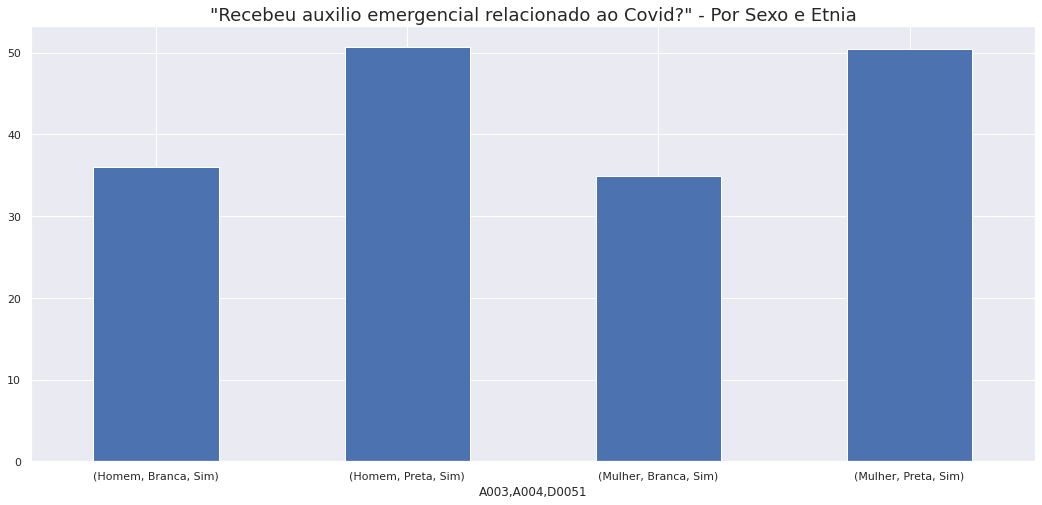

In [ ]:
auxilio_sexo_etnia.loc[(['Homem','Mulher']),(['Branca','Preta']),('Sim')].plot.bar(figsize = (18,8))
plt.title('"Recebeu auxilio emergencial relacionado ao Covid?" - Por Sexo e Etnia', fontsize = 18)
plt.xticks(rotation = 0)

plt.show()

### Trabalho Remoto, por Sexo e Etnia

In [ ]:
# A003 - Sexo
#           1 = Homem  |  2 = Mulher

# A004 - Cor ou Raça 
#        1 = Branca  |  2 = Preta | 3 = Amarela | 4 = Parda | 5 = Indígena

# CO13 - Na semana passada, estava em trabalho remoto? 
#                                 1 = Sim  |  2 = Não

remoto_sexo_etnia = pnad_cov.groupby(['A003','A004'])['C013'].value_counts(normalize = True) * 100

In [ ]:
remoto_sexo_etnia.index.set_levels([remoto_sexo_etnia.index.levels[0].map({1 : 'Homem',  2 : 'Mulher'}),
                                     remoto_sexo_etnia.index.levels[1].map({1 : 'Branca',  2 : 'Preta', 
                                                                              3 : 'Amarela', 4 : 'Parda', 
                                                                              5 : 'Indígena', 9: 'Não Disponível'}),
                                     remoto_sexo_etnia.index.levels[2].map({1:'Sim', 2:'Não'})], 
                                    level=[0,1,2],
                                    inplace = True)

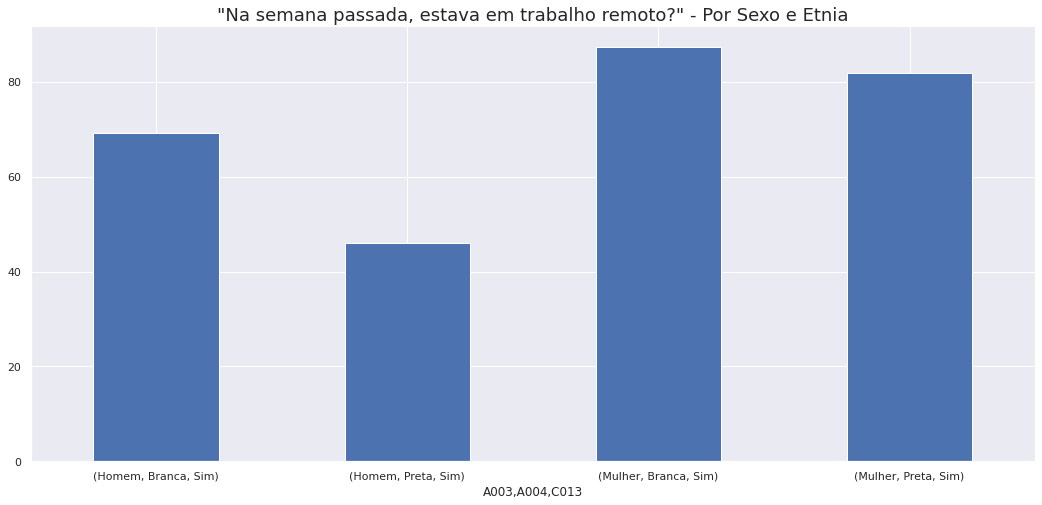

In [ ]:
remoto_sexo_etnia.loc[(['Homem','Mulher']),(['Branca','Preta']),('Sim')].plot.bar(figsize = (18,8))
plt.title('"Na semana passada, estava em trabalho remoto?" - Por Sexo e Etnia', fontsize = 18)
plt.xticks(rotation = 0)

plt.show()

### Trabalho Remoto, por Nível de Instrução

In [ ]:
remoto_educacao = pnad_cov.groupby('A005')['C013'].value_counts(normalize = True) * 100

In [ ]:
#1: 'Sem Instrução', 2:'Fundamental Incompleto', 3:'Fundamental Completo',
#4:'Médio Incompleto', 5:'Médio Completo', 6: 'Superior Incompleto', 
#7: 'Superior Completo', 8: 'Pós Graduacao'

In [ ]:
remoto_educacao.index.set_levels([remoto_educacao.index.levels[0].map({1: 'Sem Instrução', 2:'Fundamental Incompleto', 
                                                                       3:'Fundamental Completo', 4:'Médio Incompleto',
                                                                       5:'Médio Completo', 6: 'Superior Incompleto',
                                                                       7: 'Superior Completo', 8: 'Pós Graduacao'}),
                                    remoto_educacao.index.levels[1].map({1:'Sim', 2:'Não'})], 
                                    level=[0,1],
                                    inplace = True)

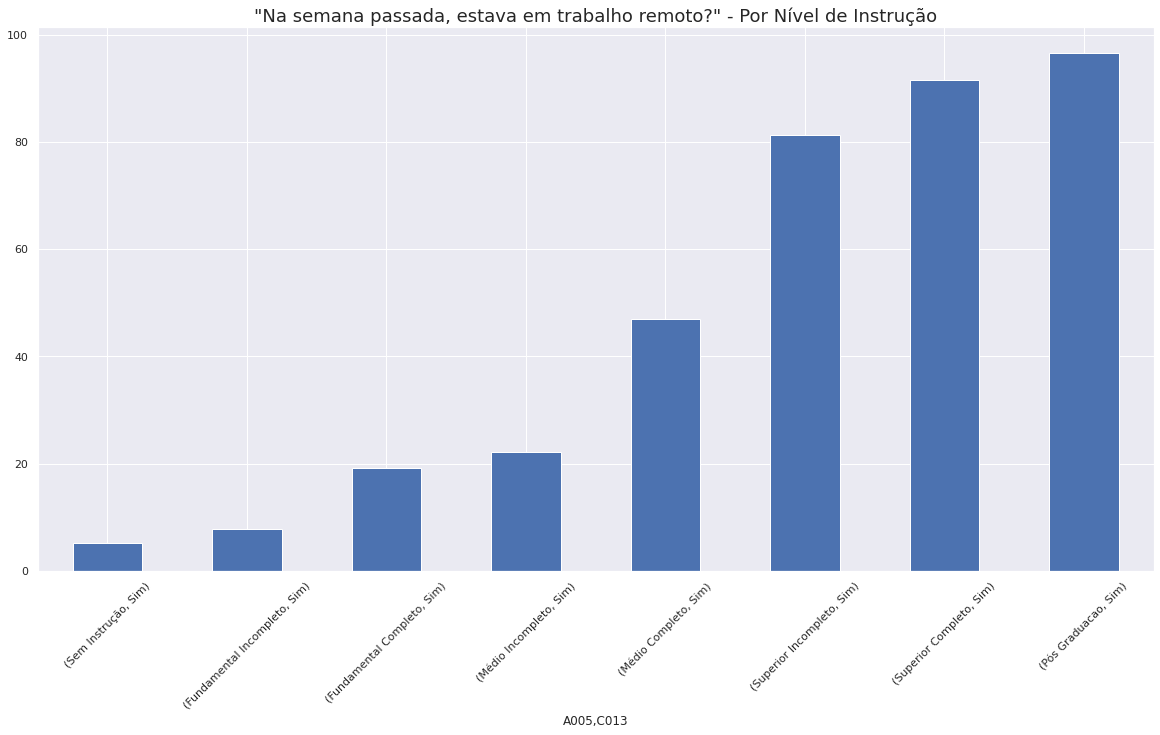

In [ ]:
remoto_educacao.loc[(['Sem Instrução','Fundamental Incompleto',
                     'Fundamental Completo','Médio Incompleto',
                     'Médio Completo','Superior Incompleto',
                     'Superior Completo','Pós Graduacao']),('Sim')].plot.bar(figsize = (20,10))
plt.title('"Na semana passada, estava em trabalho remoto?" - Por Nível de Instrução',fontsize = 18)
plt.xticks(rotation = 45)

plt.show()

## Regressão e Modelagem (statsmodels)

Versão inicial de um modelo de Mincer para determinação do prêmio salarial, necessita ajuste de endogeneidade e uso de variáveis instrumentais.

In [ ]:
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# features: idade A002, 
#           sexo A003, 
#           raca A004, 
#           educ A005,
#           salario C01012
#           fundamental (dummy - 1 fundamental completo, 0 caso contrário), 
#           medio (dummy - 1 médio completo, 0 caso contrário), 
#           superior (dummy - 1 superior completo, 0 caso contrário), 
#           posgrad (dummy - 1 pós graduação completa, 0 caso contrário)

dados = pnad_cov[['A002','A003','A005','A004','C01012']].dropna()
dados.columns = ['idade','sexo', 'educ','cor','salario']

In [ ]:
# Criando variáveis log salario e quadrado da idade
dados['log_salario'] = np.log(dados['salario'])
dados['idade_quad'] = dados['idade']**2

In [ ]:
# Dummies de nível de educação
dados['fundamental'] = np.where(dados['educ'] == 3, 1, 0)
dados['medio'] = np.where(dados['educ'] == 5, 1, 0)
dados['grad'] = np.where(dados['educ'] == 7, 1, 0)
dados['pos_grad'] = np.where(dados['educ'] == 8, 1, 0)

In [ ]:
dados['genero'] = np.where(dados['sexo'] == 1, 1, 0)

In [ ]:
# Selecionando parte da amostra de indivíduos entre 18 e 65 anos, para melhor representação da idade de um indivíduo no mercado de trabalho
dados = dados[np.logical_and(dados.idade >=18, dados.idade <=65)]

In [ ]:
dados

,idade,sexo,educ,cor,salario,log_salario,idade_quad,fundamental,medio,grad,pos_grad,etnia,genero
0,35,1,5,4,1045.0,6.951772,1225,0,1,0,0,0,1
1,29,2,7,4,1045.0,6.951772,841,0,0,1,0,0,0
5,21,2,3,2,1045.0,6.951772,441,1,0,0,0,0,0
7,47,1,2,4,2000.0,7.600902,2209,0,0,0,0,0,1
16,62,2,2,4,600.0,6.396930,3844,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
349291,24,2,6,4,2100.0,7.649693,576,0,0,0,0,0,0
349296,25,1,4,4,1700.0,7.438384,625,0,0,0,0,0,1
349298,56,1,5,1,1800.0,7.495542,3136,0,1,0,0,1,1
349301,44,2,3,4,1045.0,6.951772,1936,1,0,0,0,0,0


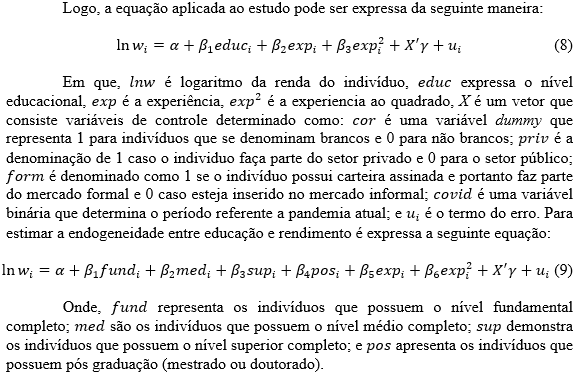

In [ ]:
# Modelo
reg = smf.ols('''log_salario ~ C(fundamental) + 
                               C(medio) + 
                               C(grad) + 
                               C(pos_grad) + 
                               idade + 
                               idade_quad + 
                               C(genero) + 
                               C(etnia)''',
              dados).fit()

In [ ]:
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:            log_salario   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     6580.
Date:                Tue, 04 May 2021   Prob (F-statistic):               0.00
Time:                        00:50:11   Log-Likelihood:            -1.3843e+05
No. Observations:              127361   AIC:                         2.769e+05
Df Residuals:                  127352   BIC:                         2.770e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.6256    

### Modelo com anos de educação

In [ ]:
# Teste de modelo que substitui dummies de educação por estimativa de anos de educação conforme escolaridade declarada
dados['anos_educ'] = dados['educ'].map({
    1: 0,
    2: 6,
    3: 9,
    4: 9,
    5: 18,
    6: 18,
    7: 22,
    8: 25,
})

In [ ]:
dados

,idade,sexo,educ,cor,salario,log_salario,idade_quad,fundamental,medio,grad,pos_grad,etnia,genero,anos_educ
0,35,1,5,4,1045.0,6.951772,1225,0,1,0,0,0,1,17
1,29,2,7,4,1045.0,6.951772,841,0,0,1,0,0,0,22
5,21,2,3,2,1045.0,6.951772,441,1,0,0,0,0,0,9
7,47,1,2,4,2000.0,7.600902,2209,0,0,0,0,0,1,5
16,62,2,2,4,600.0,6.396930,3844,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349291,24,2,6,4,2100.0,7.649693,576,0,0,0,0,0,0,17
349296,25,1,4,4,1700.0,7.438384,625,0,0,0,0,0,1,9
349298,56,1,5,1,1800.0,7.495542,3136,0,1,0,0,1,1,17
349301,44,2,3,4,1045.0,6.951772,1936,1,0,0,0,0,0,9


In [ ]:
reg_anos = smf.ols('''log_salario ~ anos_educ +
                               idade + 
                               idade_quad + 
                               C(genero) + 
                               C(etnia)''',
              dados).fit()

In [ ]:
print(reg_anos.summary())

                            OLS Regression Results                            
Dep. Variable:            log_salario   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                 1.034e+04
Date:                Tue, 04 May 2021   Prob (F-statistic):               0.00
Time:                        01:15:32   Log-Likelihood:            -1.3876e+05
No. Observations:              127361   AIC:                         2.775e+05
Df Residuals:                  127355   BIC:                         2.776e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.5127      0.023    196.

R quadrado de ambos os modelos está adequado com o estabelecido na literatura, mas prêmio salarial  é superestimado a partir da graduação, aprimorar a metodologia de ajuste em anos de educação e construir modelo mais robusto.